In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout, concatenate
from keras.layers.embeddings import Embedding
from keras.utils import plot_model

In [2]:
df = pd.read_csv('../input/clickid/annotated/combined/csv/all_agree.csv')
df.head()

,title,label,label_score
0,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",non-clickbait,0
1,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,non-clickbait,0
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1
3,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",non-clickbait,0
4,MPR: Amandemen UUD 1945 Tak Akan Melebar ke Ma...,non-clickbait,0


In [3]:
df['label_score'].value_counts()

0    5297
1    3316
Name: label_score, dtype: int64

In [4]:
def find_punc(x, punc):
    count = 0
    for char in x:
        if char == punc:
            count += 1
    return count

In [5]:
df['comma_count']       = df['title'].apply(lambda x: find_punc(x,','))
df['fullstop_count']    = df['title'].apply(lambda x: find_punc(x,'.'))
df['exclamation_count'] = df['title'].apply(lambda x: find_punc(x,'!'))
df['question_count']    = df['title'].apply(lambda x: find_punc(x,'?'))
df['colon_count']       = df['title'].apply(lambda x: find_punc(x,':'))
df['semicolon_count']   = df['title'].apply(lambda x: find_punc(x,';'))
df['apostrophe_count']  = df['title'].apply(lambda x: find_punc(x,'\''))

In [6]:
df.shape

(8613, 10)

In [7]:
def find_uppercase(x):
    count = 0
    for char in x:
        if char.isupper() :
            count +=1
    return count

def find_lowercase(x):
    count = 0
    for char in x:
        if char.islower() :
            count += 1
    return count

def find_number(x):
    return len(re.findall('[0-9]', x))

In [8]:
df['uppercase_count'] = df['title'].apply(find_uppercase)
df['lowercase_count'] = df['title'].apply(find_lowercase)
df['number_count'] = df['title'].apply(find_number)

In [9]:
df.shape

(8613, 13)

In [10]:
def clean(text):
    # Lowering letters
    text = text.lower()
    # Removing punctuations
    text = re.sub('[,.!?:;\']', '', text)
    # Tokenization
    word_tokens = word_tokenize(text)    
    # Joining words
    text = (' '.join(word_tokens))
    return text

In [11]:
df['cleaned_title'] = df['title'].apply(clean)

In [12]:
df[['title', 'cleaned_title']]

,title,cleaned_title
0,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",masuk radar pilwalkot medan menantu jokowi ber...
1,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,malaysia sudutkan ri isu kabut asap hingga inv...
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,viral driver ojol di bekasi antar pesanan maka...
3,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",kemensos salurkan rp 73 m bagi korban kerusuha...
4,MPR: Amandemen UUD 1945 Tak Akan Melebar ke Ma...,mpr amandemen uud 1945 tak akan melebar ke man...
...,...,...
8608,Twice Rilis Teaser MV 'Feel Special' Jelang Co...,twice rilis teaser mv feel special jelang come...
8609,"Asap Karhutla Riau Mulai Merambah Ke Nias, BM...",asap karhutla riau mulai merambah ke nias bmkg...
8610,"Tolak RUU Pertanahan, Ribuan Petani Siap Gelar...",tolak ruu pertanahan ribuan petani siap gelar ...
8611,Ada Niat Tambah Momongan Tanpa Ikut Program Ha...,ada niat tambah momongan tanpa ikut program ha...


In [13]:
df.columns

Index(['title', 'label', 'label_score', 'comma_count', 'fullstop_count',
       'exclamation_count', 'question_count', 'colon_count', 'semicolon_count',
       'apostrophe_count', 'uppercase_count', 'lowercase_count',
       'number_count', 'cleaned_title'],
      dtype='object')

In [14]:
X = df.iloc[:,3:]
y = df.iloc[:,2]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=77)

In [16]:
print(X_train.shape)
print(X_test.shape)

(6890, 11)
(1723, 11)


# Word-to-number mapping

In [17]:
X_train_title = X_train['cleaned_title']
X_test_title = X_test['cleaned_title']

X_train_punc = X_train.drop('cleaned_title', axis=1)
X_test_punc = X_test.drop('cleaned_title', axis=1)

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_title)

X_train_title = tokenizer.texts_to_sequences(X_train_title)
X_test_title = tokenizer.texts_to_sequences(X_test_title)

In [19]:
#tokenizer.word_index

{'di': 1,
 'ini': 2,
 'dan': 3,
 'yang': 4,
 'ke': 5,
 'jadi': 6,
 'kpk': 7,
 '2019': 8,
 'indonesia': 9,
 'tak': 10,
 'untuk': 11,
 'dengan': 12,
 'habibie': 13,
 'dari': 14,
 'dpr': 15,
 'polisi': 16,
 'jokowi': 17,
 'saat': 18,
 'soal': 19,
 'anak': 20,
 'akan': 21,
 'uu': 22,
 'mahasiswa': 23,
 'ada': 24,
 'minta': 25,
 'baru': 26,
 'bikin': 27,
 'demo': 28,
 'bisa': 29,
 'bj': 30,
 '3': 31,
 'hingga': 32,
 'asap': 33,
 'hari': 34,
 'kota': 35,
 'vs': 36,
 'tahun': 37,
 '5': 38,
 'papua': 39,
 'gara': 40,
 'revisi': 41,
 'orang': 42,
 '4': 43,
 '2': 44,
 'usai': 45,
 'warga': 46,
 'sebut': 47,
 'rumah': 48,
 'bakal': 49,
 'begini': 50,
 '1': 51,
 'liga': 52,
 'sinopsis': 53,
 'rp': 54,
 'dunia': 55,
 'sudah': 56,
 'kabut': 57,
 'karena': 58,
 'dalam': 59,
 'foto': 60,
 'siap': 61,
 'jakarta': 62,
 'ibu': 63,
 'jalan': 64,
 'gelar': 65,
 'pemerintah': 66,
 'masih': 67,
 'dki': 68,
 'mobil': 69,
 'apa': 70,
 'karhutla': 71,
 'kasus': 72,
 'video': 73,
 'aksi': 74,
 'korban': 75,
 'ep

In [20]:
vocab_size = len(tokenizer.word_index)
vocab_size

12265

# Make all texts having the exact same length

In [22]:
lengths = []
for sentence in X_train_title:
    lengths.append(len(sentence))

print('Longest sentence\t:', max(lengths))
print('Shortest sentence\t:', min(lengths))
print('Average length\t\t:', np.mean(lengths))

Longest sentence	: 19
Shortest sentence	: 2
Average length		: 9.738896952104499


In [23]:
X_train_title = sequence.pad_sequences(X_train_title, maxlen=19)
X_test_title = sequence.pad_sequences(X_test_title, maxlen=19)

In [24]:
X_train_title[0]

array([   0,    0,    0,    0,    0,    0,    0,    0, 1726,  384, 6388,
          3, 1527,  122, 1977,  179, 1020,  683, 1245], dtype=int32)

# Class weight

In [25]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 [0, 1], 
                                                 y_train.values)
class_weights

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1], y=[0 1 1 ... 0 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([0.81192552, 1.30147337])

In [26]:
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.811925524393118, 1: 1.3014733660748017}

In [27]:
print(X_train_title.shape)
print(X_test_title.shape)

(6890, 19)
(1723, 19)


# Build the 2-inputs neural net

In [28]:
tf.random.set_seed(99)

lstm_input = Input(shape=(19,))
lstm = Embedding(input_dim=vocab_size+1, 
                 output_dim=32, input_length=19)(lstm_input)
lstm = LSTM(3)(lstm)
lstm = Dropout(rate=0.5)(lstm)
lstm = Dense(3, activation='sigmoid')(lstm)
lstm_model = Model(inputs=lstm_input, outputs=lstm)

In [29]:
dense_input = Input(shape=(10,))
dense = Dropout(rate=0.5)(dense_input)
dense = Dense(3, activation='sigmoid')(dense)
dense_model = Model(inputs=dense_input, outputs=dense)

In [30]:
print(X_train_punc.shape)
print(X_test_punc.shape)

(6890, 10)
(1723, 10)


In [31]:
concat = concatenate([lstm_model.output, dense_model.output])
concat = Dense(6, activation='sigmoid')(concat)
concat = Dense(1, activation='sigmoid')(concat)
model = Model(inputs=[lstm_model.input, dense_model.input], 
              outputs=concat)

In [32]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 19, 32)       392512      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 3)            432         embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
_______________________________________________________________________________________

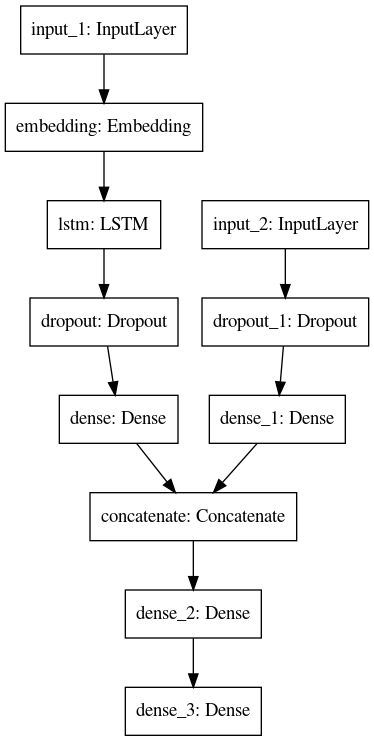

In [33]:
plot_model(model)

In [34]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

In [35]:
history = model.fit([X_train_title, X_train_punc], y_train, 
                    epochs=4, batch_size=64, 
                    class_weight=class_weight_dict,
                    validation_data=([X_test_title, X_test_punc], 
                                     y_test))

Epoch 1/4
108/108 [==============================] - 2s 17ms/step - loss: 0.6925 - acc: 0.5898 - val_loss: 0.6868 - val_acc: 0.6187
Epoch 2/4
108/108 [==============================] - 1s 14ms/step - loss: 0.6782 - acc: 0.6874 - val_loss: 0.6585 - val_acc: 0.8474
Epoch 3/4
108/108 [==============================] - 1s 12ms/step - loss: 0.6352 - acc: 0.8419 - val_loss: 0.5942 - val_acc: 0.8851
Epoch 4/4
108/108 [==============================] - 1s 11ms/step - loss: 0.5654 - acc: 0.9038 - val_loss: 0.5190 - val_acc: 0.8828


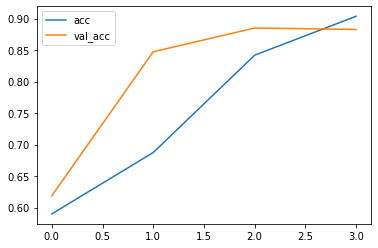

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])

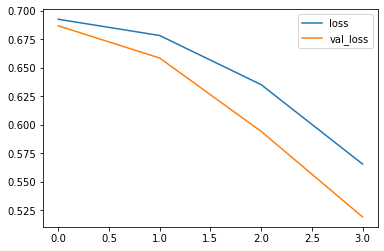

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])